# PTB Diagnostic Data

### Import libraries for later use

In [1]:
import pandas as pd
import os
import models
import types
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.mixture
from sklearn.metrics import roc_curve,precision_recall_curve,auc,accuracy_score,f1_score
import matplotlib.pyplot as plt

In [2]:
#Helper functions for getting scores and visualization
def getScores(model_name,Y_test,pred_test,metrics_df):
    fpr, tpr, _ = roc_curve(Y_test, pred_test)
    auroc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(Y_test, pred_test)
    auprc = auc(recall, precision)
    pred_test = (pred_test > 0.5).astype(np.int8)
    f1 = f1_score(Y_test, pred_test)
    acc = accuracy_score(Y_test, pred_test)
    curr_metrics = {'Name': model_name, 'f1_score': f1, "AUROC": auroc, "AUPRC": auprc, "ACC": acc}
    metrics_df = metrics_df.append(curr_metrics, ignore_index=True)
    return metrics_df

def visualize(df,title):
    plt.figure(figsize=(10,8))
    np.random.seed(0)
    n_sub_plots = 5
    for i in range(n_sub_plots):
        plt.subplot(n_sub_plots, 1, i + 1)
        plt.plot(df.iloc[np.random.choice(len(df[1])), :])
        plt.xticks([])
        plt.yticks([])

    plt.suptitle(title)
    plt.show()


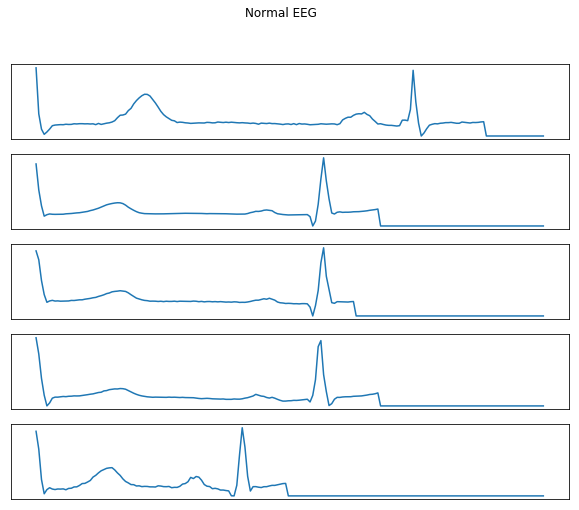

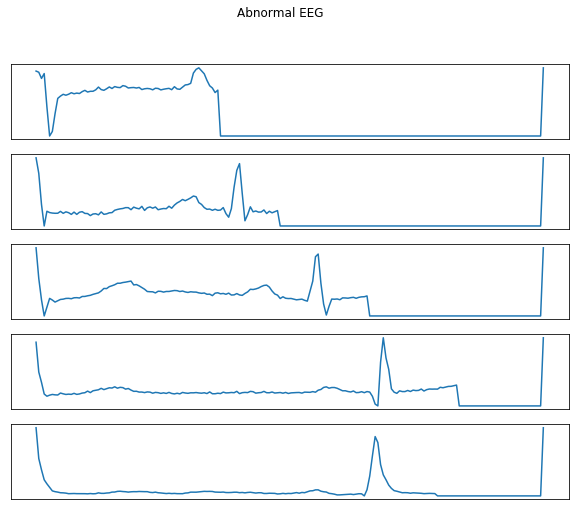

In [3]:
%matplotlib inline
#Set the gpu number you want to run on
#Caution: Setting to a number not recognizable will not run on GPU
gpu = 6 #gpu = 0
lstm_out = 100
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

df_1 = pd.read_csv("exercise_data/heartbeat/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("exercise_data/heartbeat/ptbdb_abnormal.csv", header=None)

visualize(df_1,'Normal EEG')
visualize(df_2,'Abnormal EEG')

df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(186))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(186))].values)[..., np.newaxis]

#X_ft = standard.getfeatures(X)
#X_test_ft = standard.getfeatures(X_test)

metrics_df = pd.DataFrame(data=[],columns=['Name','f1_score','AUROC','AUPRC','ACC'])

### Some Neural network models and Random forests compared to baseline code

In [4]:
models_ = [
    sklearn.mixture.GaussianMixture(n_components=2),
    sklearn.mixture.BayesianGaussianMixture(n_components=2),
    models.LSTM_Model(),
    RandomForestClassifier(n_jobs=-1),
    models.Residual_CNN(),
    models.CNN_Model(),
]

params = [
    # Gaussian mixture
    {

    },
    # Bayesian Mixture
    {

    },
    # LSTM
    {
        'verbose': [0],
        'hidden': [16, 32, 64],
        'dense': [16, 32, 64]
    },
    # RandomForestClassifier
    {
        'n_estimators' : [10, 100, 200],
        'n_jobs':  [-1]
    },
    # Residual_CNN
    {
        'deepness': range(1,6),
        'verbose': [0]
    },
    # CNN_Model
    {   
        'conv1_size': [16, 32],
        'conv2_size': [32, 64],
        'conv3_size': [128, 256],
        'dense_size': [16, 32, 64],
        'verbose': [0]
    },
    
]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train the models and report the metric scores

In [5]:
model_preds = []
for param, model in zip(params, models_):
    clf = RandomizedSearchCV(model, param, cv=2, n_iter=5, verbose=2)
    if type(model) == RandomForestClassifier or \
        type(model) == sklearn.mixture.GaussianMixture or \
        type(model) == sklearn.mixture.BayesianGaussianMixture:
        clf.fit(np.squeeze(X), Y)
        model = clf.best_estimator_
        model.getScores = types.MethodType(models.CNN_Model.getScores, model)
        _,metrics_df = model.getScores(np.squeeze(X_test), Y_test, metrics_df)
    else:
        clf.fit(X, Y)
        model = clf.best_estimator_
        pred,metrics_df = model.getScores(X_test, Y_test, metrics_df)
        model_preds.append(pred)
        
    print(metrics_df)

/home/karthikp/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ................................................. , total=   2.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s finished


              Name  f1_score     AUROC     AUPRC       ACC
0  GaussianMixture  0.737488  0.518028  0.830282  0.618001
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV]  ................................................................


/home/karthikp/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/karthikp/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV] ................................................. , total=   7.9s
[CV]  ................................................................
[CV] ................................................. , total=   7.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s finished


                      Name  f1_score     AUROC     AUPRC       ACC
0          GaussianMixture  0.737488  0.518028  0.830282  0.618001
1  BayesianGaussianMixture  0.746612  0.499639  0.829418  0.621092
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] verbose=0, hidden=16, dense=16 ..................................
Instructions for updating:
Use tf.cast instead.
5820/5820 [==============================] - 2s 325us/sample - loss: 0.5906 - acc: 0.7215
[CV] ................... verbose=0, hidden=16, dense=16, total=  38.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.8s remaining:    0.0s


[CV] verbose=0, hidden=16, dense=16 ..................................
5821/5821 [==============================] - 2s 373us/sample - loss: 0.3660 - acc: 0.8138
[CV] ................... verbose=0, hidden=16, dense=16, total= 1.2min
[CV] verbose=0, hidden=32, dense=64 ..................................
5820/5820 [==============================] - 2s 346us/sample - loss: 0.5414 - acc: 0.7215
[CV] ................... verbose=0, hidden=32, dense=64, total= 1.2min
[CV] verbose=0, hidden=32, dense=64 ..................................
5821/5821 [==============================] - 2s 398us/sample - loss: 0.1586 - acc: 0.9332
[CV] ................... verbose=0, hidden=32, dense=64, total= 3.3min
[CV] verbose=0, hidden=64, dense=16 ..................................
5820/5820 [==============================] - 2s 407us/sample - loss: 0.3771 - acc: 0.8070
[CV] ................... verbose=0, hidden=64, dense=16, total=  59.5s
[CV] verbose=0, hidden=64, dense=16 ..................................
5

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 15.7min finished


                      Name  f1_score     AUROC     AUPRC       ACC
0          GaussianMixture  0.737488  0.518028  0.830282  0.618001
1  BayesianGaussianMixture  0.746612  0.499639  0.829418  0.621092
2               LSTM_Model  0.941317  0.966186  0.986149  0.915493
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] n_jobs=-1, n_estimators=10 ......................................


/home/karthikp/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_jobs=-1, n_estimators=10, total=   5.4s
[CV] n_jobs=-1, n_estimators=10 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ....................... n_jobs=-1, n_estimators=10, total=   0.7s
[CV] n_jobs=-1, n_estimators=100 .....................................
[CV] ...................... n_jobs=-1, n_estimators=100, total=   0.6s
[CV] n_jobs=-1, n_estimators=100 .....................................
[CV] ...................... n_jobs=-1, n_estimators=100, total=   0.6s
[CV] n_jobs=-1, n_estimators=200 .....................................
[CV] ...................... n_jobs=-1, n_estimators=200, total=   0.8s
[CV] n_jobs=-1, n_estimators=200 .....................................
[CV] ...................... n_jobs=-1, n_estimators=200, total=   0.8s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.9s finished


                      Name  f1_score     AUROC     AUPRC       ACC
0          GaussianMixture  0.737488  0.518028  0.830282  0.618001
1  BayesianGaussianMixture  0.746612  0.499639  0.829418  0.621092
2               LSTM_Model  0.941317  0.966186  0.986149  0.915493
3   RandomForestClassifier  0.978343  0.952264  0.982570  0.968396
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] verbose=0, deepness=1 ...........................................
5820/5820 [==============================] - 1s 152us/sample - loss: 4.4403 - acc: 0.7215
[CV] ............................ verbose=0, deepness=1, total=  32.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.1s remaining:    0.0s


[CV] verbose=0, deepness=1 ...........................................
5821/5821 [==============================] - 1s 156us/sample - loss: 11.6435 - acc: 0.2776
[CV] ............................ verbose=0, deepness=1, total=  34.3s
[CV] verbose=0, deepness=2 ...........................................
5820/5820 [==============================] - 1s 154us/sample - loss: 11.6288 - acc: 0.2785
[CV] ............................ verbose=0, deepness=2, total=  36.7s
[CV] verbose=0, deepness=2 ...........................................
5821/5821 [==============================] - 1s 160us/sample - loss: 4.4259 - acc: 0.7224
[CV] ............................ verbose=0, deepness=2, total=  38.0s
[CV] verbose=0, deepness=3 ...........................................
5820/5820 [==============================] - 1s 170us/sample - loss: 11.6288 - acc: 0.2785
[CV] ............................ verbose=0, deepness=3, total=  38.8s
[CV] verbose=0, deepness=3 ..........................................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.1min finished
/home/karthikp/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                      Name  f1_score     AUROC     AUPRC       ACC
0          GaussianMixture  0.737488  0.518028  0.830282  0.618001
1  BayesianGaussianMixture  0.746612  0.499639  0.829418  0.621092
2               LSTM_Model  0.941317  0.966186  0.986149  0.915493
3   RandomForestClassifier  0.978343  0.952264  0.982570  0.968396
4             Residual_CNN  0.000000  0.500000  0.861044  0.277911
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] verbose=0, dense_size=16, conv3_size=128, conv2_size=64, conv1_size=16 
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
5820/5820 [==============================] - 1s 181us/sample - loss: 0.1059 - acc: 0.9595
[CV]  verbose=0, dense_size=16, conv3_size=128, conv2_size=64, conv1_size=16, total= 1.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV] verbose=0, dense_size=16, conv3_size=128, conv2_size=64, conv1_size=16 
5821/5821 [==============================] - 1s 181us/sample - loss: 0.0531 - acc: 0.9825
[CV]  verbose=0, dense_size=16, conv3_size=128, conv2_size=64, conv1_size=16, total= 1.8min
[CV] verbose=0, dense_size=64, conv3_size=128, conv2_size=32, conv1_size=16 
5820/5820 [==============================] - 1s 182us/sample - loss: 0.0244 - acc: 0.9940
[CV]  verbose=0, dense_size=64, conv3_size=128, conv2_size=32, conv1_size=16, total= 2.6min
[CV] verbose=0, dense_size=64, conv3_size=128, conv2_size=32, conv1_size=16 
5821/5821 [==============================] - 1s 187us/sample - loss: 0.0387 - acc: 0.9861
[CV]  verbose=0, dense_size=64, conv3_size=128, conv2_size=32, conv1_size=16, total= 2.1min
[CV] verbose=0, dense_size=16, conv3_size=256, conv2_size=64, conv1_size=32 
5820/5820 [==============================] - 1s 199us/sample - loss: 0.0159 - acc: 0.9947
[CV]  verbose=0, dense_size=16, conv3_size=256, conv2_si

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 21.0min finished


                      Name  f1_score     AUROC     AUPRC       ACC
0          GaussianMixture  0.737488  0.518028  0.830282  0.618001
1  BayesianGaussianMixture  0.746612  0.499639  0.829418  0.621092
2               LSTM_Model  0.941317  0.966186  0.986149  0.915493
3   RandomForestClassifier  0.978343  0.952264  0.982570  0.968396
4             Residual_CNN  0.000000  0.500000  0.861044  0.277911
5                CNN_Model  0.991920  0.997566  0.998834  0.988320


# Ensemble Methods

In [6]:
model_preds = np.array(model_preds)
model_preds = np.squeeze(model_preds)

## Average Ensemble

In [7]:
#Avg ensemble:
avg_pred = np.mean(model_preds,axis=0)
metrics_df = getScores('Ensemble(Avg)',Y_test=Y_test,pred_test=avg_pred,metrics_df=metrics_df)

## Logistic Regression Ensemble

In [8]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(n_jobs=-1)
X_lg = np.transpose(model_preds,[1,0])
lg.fit(X_lg,Y_test)
lg_pred = lg.predict_proba(X_lg)[:,1]
metrics_df = getScores('Ensemble(LG)',Y_test=Y_test,pred_test=lg_pred,metrics_df=metrics_df)

/home/karthikp/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/karthikp/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 28.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [9]:
print(metrics_df)

                      Name  f1_score     AUROC     AUPRC       ACC
0          GaussianMixture  0.737488  0.518028  0.830282  0.618001
1  BayesianGaussianMixture  0.746612  0.499639  0.829418  0.621092
2               LSTM_Model  0.941317  0.966186  0.986149  0.915493
3   RandomForestClassifier  0.978343  0.952264  0.982570  0.968396
4             Residual_CNN  0.000000  0.500000  0.861044  0.277911
5                CNN_Model  0.991920  0.997566  0.998834  0.988320
6            Ensemble(Avg)  0.961340  0.995275  0.997063  0.946067
7             Ensemble(LG)  0.992171  0.996106  0.997391  0.988664
